## Henry Problem

![Henery and Elder boundary conditions](https://www.researchgate.net/publication/362716965/figure/fig1/AS:11431281079483285@1660716381273/FIGURE-E-A-Henry-problem-boundary-conditions-B-Elder-problem-boundary-conditions_W640.jpg)

A la izquierda (Figura A)  se muestran las condiciones de frontera para el problema de Henry.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sp

plt.style.use(["seaborn-v0_8-darkgrid", "seaborn-v0_8-colorblind", "seaborn-v0_8-talk"])
plt.rcParams["legend.frameon"] = True
plt.rcParams["legend.shadow"] = True
plt.rcParams["legend.framealpha"] = 0.1

import calfem.geometry as cfg
import calfem.mesh as cfm
import calfem.vis_mpl as cfv

from scipy.integrate import solve_ivp

### Geometry

Text(0.5, 1.0, 'Geometry')

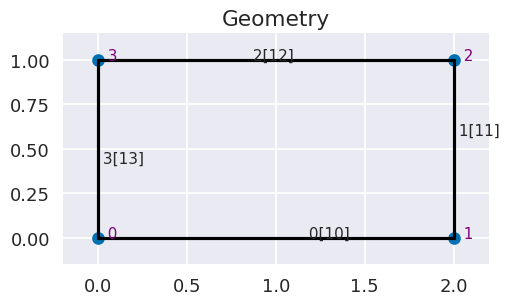

In [2]:
length = 2
height = 1

g = cfg.Geometry()

# Points
g.point([0, 0])
g.point([length, 0])
g.point([length, height])
g.point([0, height])

# Lines
bottom = 10
right = 11
top = 12
left = 13
g.line([0, 1], marker=bottom)
g.line([1, 2], marker=right)
g.line([2, 3], marker=top)
g.line([3, 0], marker=left)

# surface
surface = 1
g.surface([0, 1, 2, 3], marker=surface)




# geometry plot
plt.figure(figsize=(8,3))
cfv.draw_geometry(g,draw_axis=True)
plt.title("Geometry")

### Mesh

Text(0.5, 0.9, 'el_size_factor=0.1, N=274 nodes')

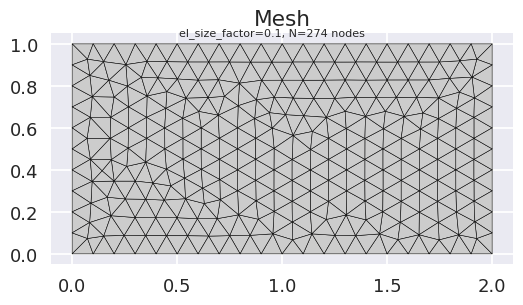

In [3]:
mesh = cfm.GmshMesh(g,el_size_factor=0.1)

coords, edof, dofs, bdofs, elementmarkers = mesh.create()
verts, faces, vertices_per_face, is_3d = cfv.ce2vf(
    coords,
    edof,
    mesh.dofs_per_node,
    mesh.el_type
)

plt.figure(figsize=(8,3))
cfv.draw_mesh(
    coords=coords,
    edof=edof,
    dofs_per_node=mesh.dofs_per_node,
    el_type=mesh.el_type,
    filled=True
)
plt.title(f"Mesh")
plt.suptitle(f"el_size_factor={mesh.el_size_factor}, N={coords.shape[0]} nodes", fontsize=8, y=0.90)

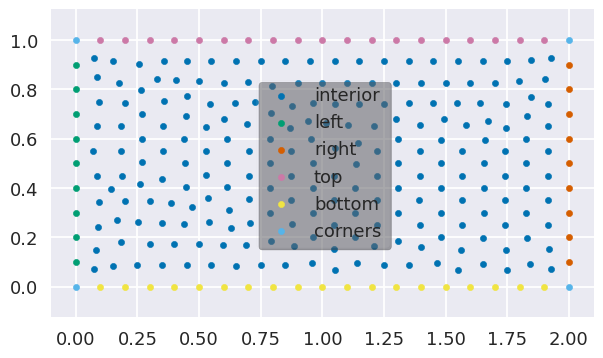

In [4]:
# nodes 
left_nodes = np.asarray(bdofs[left]) - 1
right_nodes = np.asarray(bdofs[right]) - 1
top_nodes = np.asarray(bdofs[top]) - 1
bottom_nodes = np.asarray(bdofs[bottom]) - 1

# removing corner nodes from each side
bottom_nodes = np.setdiff1d(bottom_nodes, [0,1])
top_nodes = np.setdiff1d(top_nodes, [2,3])
right_nodes = np.setdiff1d(right_nodes, [1,2])
left_nodes = np.setdiff1d(left_nodes, [0,3])

boundary_nodes = np.hstack(([0,1,2,3],left_nodes, right_nodes, top_nodes, bottom_nodes))

interior_nodes = np.setdiff1d(np.arange(coords.shape[0]), boundary_nodes)

# plotting nodes
nodes_to_plot = (
    interior_nodes,
    left_nodes,
    right_nodes,
    top_nodes,
    bottom_nodes,
    [0,1,2,3]
)
labels = (
    "interior",
    "left",
    "right",
    "top",
    "bottom",
    "corners"
)
plt.figure(figsize=(7,4))
for nodes, label in zip(nodes_to_plot, labels):
    plt.scatter(
        coords[nodes, 0],
        coords[nodes, 1],
        label=label,
        s=20
    )
plt.axis("equal")
plt.legend(loc="center")

### Problem Discretization

In [6]:
# Paramters laplacian
L = np.array([0,0,0,1,0,1])
source = lambda p: 0
k = lambda p: 1
neumann_condition = lambda p: 0

# Discretization
from GFDMI import GFDMI_2D_problem as gfdmi

# Psi lapacian operator
problem = gfdmi(coords, faces, L, source)
problem.material("surfce", k, interior_nodes)
problem.dirichlet_boundary("top", top_nodes, lambda p: 1)
problem.dirichlet_boundary("bottom", bottom_nodes, lambda p: 0)
problem.neumann_boundary("left", k, left_nodes, neumann_condition)
problem.neumann_boundary("right", k, right_nodes, neumann_condition)
problem.dirichlet_boundary("top corners", [2,3], lambda p: 1)
problem.dirichlet_boundary("bottom corners", [0,1], lambda p: 0)

D2psi, F2psi = problem.continuous_discretization()

# Psi Dx operator
problem.L = np.array([0,1,0,0,0,0])
Dxpsi, Fxpsi = problem.continuous_discretization()

# Psi Dy operator
problem.L = np.array([0,0,1,0,0,0])
Dypsi, Fypsi = problem.continuous_discretization()

# C laplacian operator
problem = gfdmi(coords, faces, L, source)
problem.material("surfce", k, interior_nodes)
problem.dirichlet_boundary("left", left_nodes, lambda p: 0)
problem.dirichlet_boundary("right", right_nodes, lambda p: 1)
problem.neumann_boundary("top", k, top_nodes, neumann_condition)
problem.neumann_boundary("bottom", k, bottom_nodes, neumann_condition)
problem.dirichlet_boundary("left corners", [0,3], lambda p: 0)
problem.dirichlet_boundary("right corners", [1,2], lambda p: 1)

D2c, F2c = problem.continuous_discretization()

# C Dx operator
L = np.array([0,1,0,0,0,0])
Dxc, Fxc = problem.continuous_discretization()

# C Dy operator
problem.L = np.array([0,0,1,0,0,0])
Dyc, Fyc = problem.continuous_discretization()

### Problem Assembling

In [7]:
a = 0.2637
b = 0.1

Dxcpsi = Dxc.copy()
Dxcpsi = sp.lil_matrix(Dxcpsi)
Fxcpsi = Fxc.copy()

Dxcpsi[boundary_nodes,:] = 0
Fxcpsi[boundary_nodes] = 0

Dypsic = Dypsi.copy()
Dypsic = sp.lil_matrix(Dypsic)
Fypsic = Fypsi.copy()

Dypsic[boundary_nodes,:] = 0
Fypsic[boundary_nodes] = 0

Dxpsic = Dxpsi.copy()
Dxpsic = sp.lil_matrix(Dxpsic)
Fxpsic = Fxpsi.copy()

Dxpsic[boundary_nodes,:] = 0
Fxpsic[boundary_nodes] = 0

# Assembling
# Lineal part (Matrix A)
N = coords.shape[0]
print("N = ", N)
A = sp.vstack((
    sp.hstack((
        D2psi, -1/a * Dxcpsi
    )),
    sp.hstack((
        np.zeros((N,N)), D2c
    ))
))

# known part (Vector Fl)
Fl = np.hstack((
    - F2psi  +  1/a * Fxcpsi,
    - F2c
))

# Non-lineal part (Vector B)
def B(U):
    term1 = (Dypsic@U[:N] - Fypsic) * (Dxc@U[N:] - Fxc)
    term2 = (Dxpsic@U[:N] - Fxpsic) * (Dyc@U[N:] - Fyc)
    vec2 = -1/b * (term1 - term2)
    vec1 = np.zeros(N)
    vec = np.hstack((vec1, vec2))
    return vec

# coupling right hand side
function_to_solve = lambda t,U: A@U + Fl + B(U)

# initial conditions
C0 = np.zeros(N)
Psi0 = np.zeros(N)

C0[right_nodes] = 1
C0[[1,2]] = 1
Psi0[top_nodes] = 1
Psi0[[2,3]] = 1

U0 = np.hstack((Psi0, C0))

t_span = (0, 0.21)

# solve
sol = solve_ivp(fun=function_to_solve, t_span=t_span, y0=U0, method="RK45")

U = sol.y

N =  274


/home/ricardo/miniconda3/envs/gfdm/lib/python3.10/site-packages/matplotlib/tri/_triangulation.py:181: RuntimeWarning: invalid value encountered in cast
  triangles = np.asarray(triangles, dtype=np.int32)


(np.float64(0.0), np.float64(2.0), np.float64(0.0), np.float64(1.0))

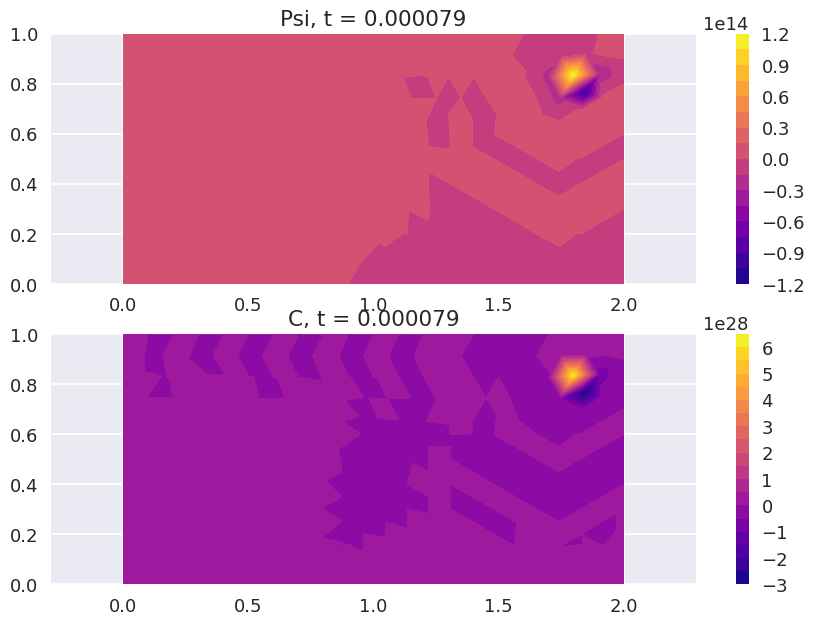

In [8]:
#%% Animation
from matplotlib.animation import FuncAnimation 
fig = plt.figure()

ax1 = fig.add_subplot(2,1,1)
ax2 = fig.add_subplot(2,1,2)

index = sol.t.shape[0] - 1
cont1 = ax1.tricontourf(
    coords[:,0],
    coords[:,1],
    U[:N,index],
    cmap="plasma",
    levels=20
)
fig.colorbar(cont1)
ax1.set_title(f"Psi, t = {sol.t[index]:.6f}")
ax1.axis("equal")

cont2 = ax2.tricontourf(
    coords[:,0],
    coords[:,1],
    U[N:,index],
    cmap="plasma",
    levels=20
)
fig.colorbar(cont2)
ax2.set_title(f"C, t = {sol.t[index]:.6f}")
ax2.axis("equal")